In [109]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/데이터스쿨 공부코드/project/Final_project


In [ ]:
# # 코랩 한글폰트 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import platform as pf
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import datetime
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
# 마이너스 기호 문제 해결하기
# mpl.rcParams['axes.unicode_minus'] = False

In [ ]:
customer_buyinginfo_df = pd.read_csv('./customer_buyinginfo_df.csv')
len(customer_buyinginfo_df)

1468

---


In [ ]:
# 2019년 말일 기준으로 최근 거래일을 일로 환산하기
today = datetime.date(2019, 12, 31)

rfm_df = customer_buyinginfo_df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']].copy()
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in customer_buyinginfo_df['최근거래날짜']]    # +1일
rfm_df.columns = ['CustomerID', 'R', 'F', 'M']
rfm_df


,CustomerID,R,F,M
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


In [ ]:
rfm_df.describe()

,R,F,M
count,1468.000000,1468.000000,1468.000000
mean,145.292234,18.141008,3460.302548
std,101.936959,24.976414,5519.945748
min,1.000000,1.000000,6.990000
25%,56.000000,5.000000,714.750000
50%,132.000000,11.000000,1899.320000
75%,221.000000,23.000000,4273.347500
max,365.000000,328.000000,84405.830000


- 2019년 12월 31일 기준, 고객 한 명 당 평균 거래일은 145일 전이다.
- 구매횟수의 평균은 18회, 총결제금액 평균은 3453.9달러이다.

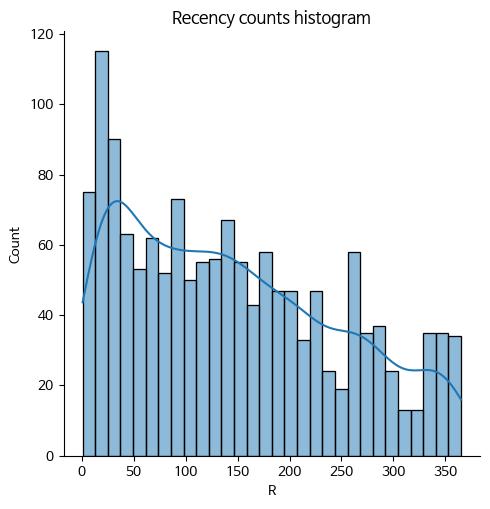

In [ ]:
sns.displot(rfm_df['R'], kind='hist', bins=30, kde=True)
plt.title('Recency counts histogram')
plt.show()

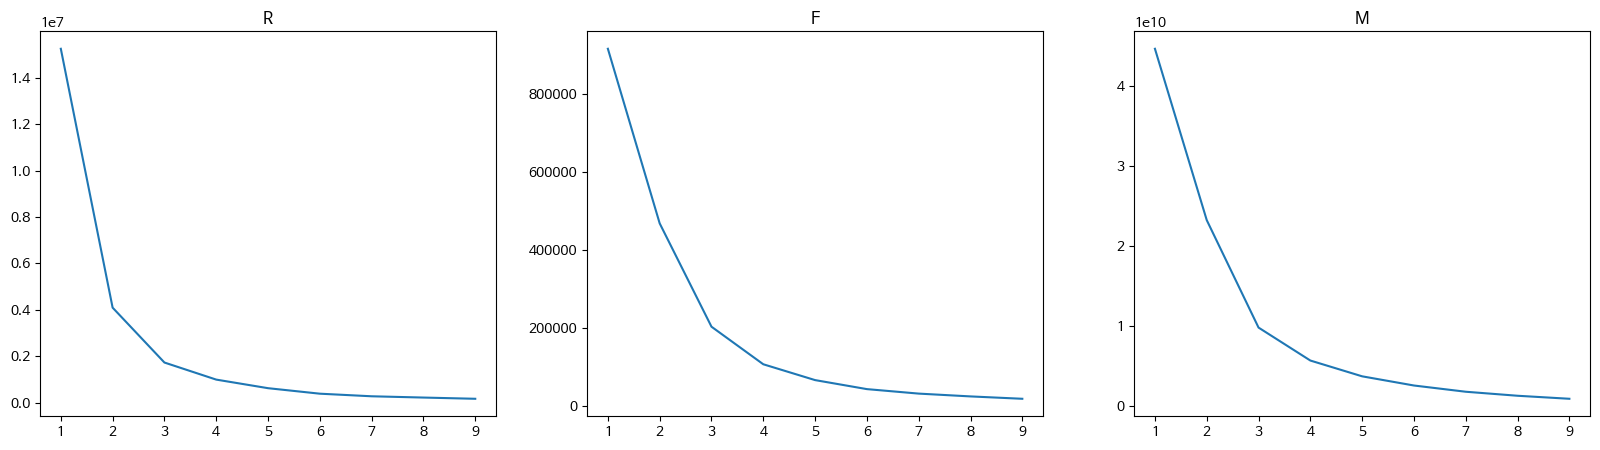

In [ ]:
# Recency kmeans 계산을 위한 elbow point: 엘보우 포인트는 클러스터의 수가 증가함에 따라 클러스터 내 오차 제곱합(SSE: Sum of Squared Errors)이 어떻게 변하는지를 보여줌. 엘보우 포인트는 SSE의 감소율이 급격하게 줄어드는 지점으로, 이 지점에서는 클러스터의 수를 증가시켜도 성능이 크게 향상되지 않는다는 것을 의미
from sklearn.cluster import KMeans

recency_point = {}
frequency_point = {}
monetary_point = {}

rfm_df_recency = rfm_df[['R']].copy()
rfm_df_frequency = rfm_df[['F']].copy()
rfm_df_monetary = rfm_df[['M']].copy()

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_recency)
  rfm_df_recency['cluster'] = kmeans.labels_
  recency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_frequency)
  rfm_df_frequency['cluster'] = kmeans.labels_
  frequency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_df_monetary)
  rfm_df_monetary['cluster'] = kmeans.labels_
  monetary_point[k] = kmeans.inertia_

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax0 = sns.lineplot(ax=axes[0], x=list(recency_point.keys()), y=list(recency_point.values()))
ax0.set_title('R')

ax1 = sns.lineplot(ax=axes[1], x=list(frequency_point.keys()), y=list(frequency_point.values()))
ax1.set_title('F')

ax2 = sns.lineplot(ax=axes[2], x=list(monetary_point.keys()), y=list(monetary_point.values()))
ax2.set_title('M')
plt.show()

- 5개로 구분하는 것이 최적으로 보임
- pd.qcut으로 5분할

In [ ]:
# 5개 bins, 5점 기준으로 점수 부여
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["RScore"] = pd.qcut(df_["R"], 5, labels=[5, 4, 3, 2, 1])   # 5가 가장 높은 점수
    df_["FScore"] = pd.qcut(
        df_["F"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]   # method = "first"는 순위 간 동륭을 처리할 때 사용
    )
    df_["MScore"] = pd.qcut(df_["M"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFMScore"] = df_["RScore"].astype(str) + df_["FScore"].astype(str) + df_["MScore"].astype(str)   # RFMScore는 점수들의 str 조합

    return df_

rfm_score_df = get_rfm_scores(rfm_df)
rfm_score_df

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore
0,USER_0000,108,1,99.98,3,1,1,311
1,USER_0001,60,31,15308.13,4,5,5,455
2,USER_0002,74,8,1573.49,4,2,3,423
3,USER_0003,18,11,1421.96,5,3,3,533
4,USER_0004,108,13,1524.42,3,3,3,333
...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,676.73,1,1,2,112
1464,USER_1464,88,19,2606.18,4,4,4,444
1465,USER_1465,195,2,127.90,2,1,1,211
1466,USER_1466,70,1,333.80,4,1,1,411


In [ ]:
#transposition of the RFM table. This makes it easier to evaluate.
rfm_score_df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,1468.0,145.292234,101.936959,1.00,56.00,132.00,221.0000,365.00
F,1468.0,18.141008,24.976414,1.00,5.00,11.00,23.0000,328.00
M,1468.0,3460.302548,5519.945748,6.99,714.75,1899.32,4273.3475,84405.83


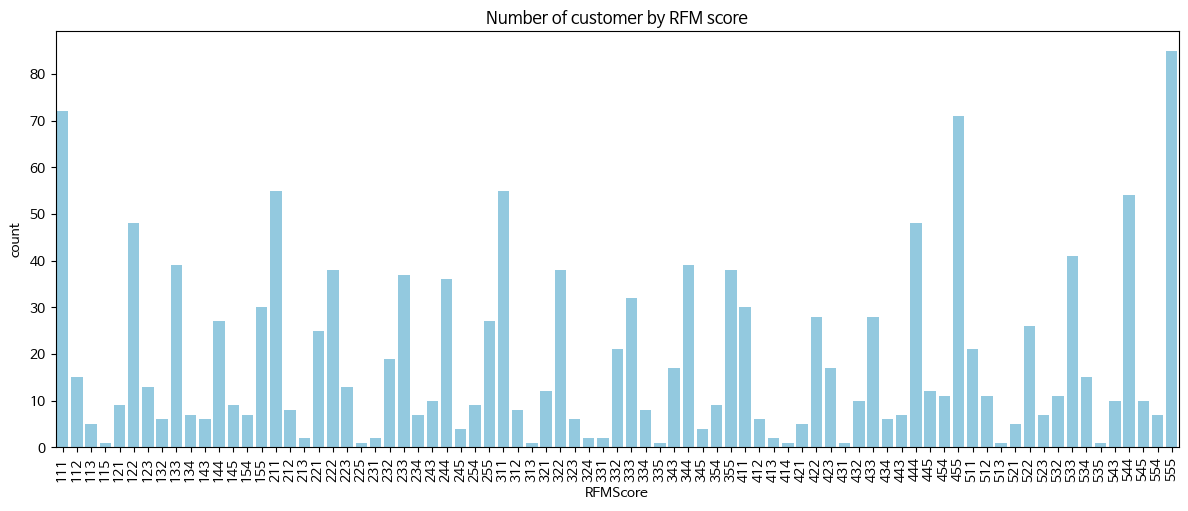

In [ ]:
plt.figure(figsize=(12, 5))
sns.countplot(rfm_score_df.sort_values('RFMScore'), x='RFMScore', color='skyblue')
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Number of customer by RFM score')
plt.show()

---

# FRM Segmentation

- 어떻게 잘라야할까?

In [ ]:
rfm_score_df.groupby('RScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RScore,,,,,,,,
5,305.0,21.944262,10.483705,1.0,14.0,21.0,30.0,41.0
4,283.0,71.250883,16.798893,42.0,59.0,70.0,87.5,100.0
3,293.0,131.320819,17.201450,101.0,117.0,132.0,146.0,162.0
2,293.0,200.563140,23.486522,163.0,178.0,202.0,221.0,249.0
1,294.0,303.367347,36.611806,250.0,269.0,297.5,337.0,365.0


In [ ]:
# RFM스코어 그룰별 Recency 시각화해보기
rfm_score_df.groupby('RFMScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RFMScore,,,,,,,,
111,72.0,300.402778,35.979125,257.0,268.25,291.0,336.00,365.0
112,15.0,302.933333,39.506720,259.0,269.00,281.0,342.50,356.0
113,5.0,301.200000,52.935810,258.0,261.00,269.0,357.00,361.0
115,1.0,269.000000,NaN,269.0,269.00,269.0,269.00,269.0
121,9.0,300.333333,34.340210,256.0,271.00,303.0,305.00,359.0
...,...,...,...,...,...,...,...,...
543,10.0,18.800000,9.235198,5.0,14.25,18.5,24.00,34.0
544,54.0,22.388889,11.560206,3.0,13.00,21.5,31.75,41.0
545,10.0,24.400000,11.796421,2.0,16.50,26.5,35.00,37.0


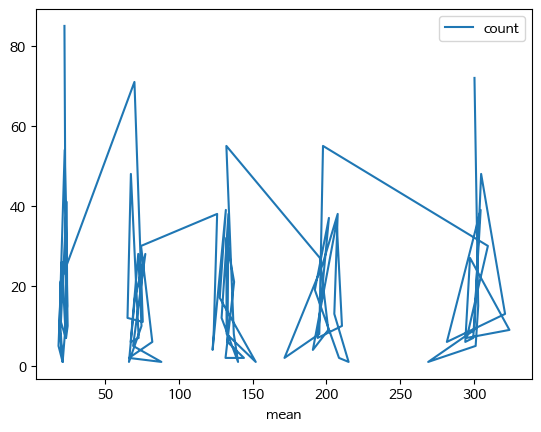

In [ ]:
rfm_score_df.groupby('RFMScore')['R'].describe().plot(x='mean', y='count');

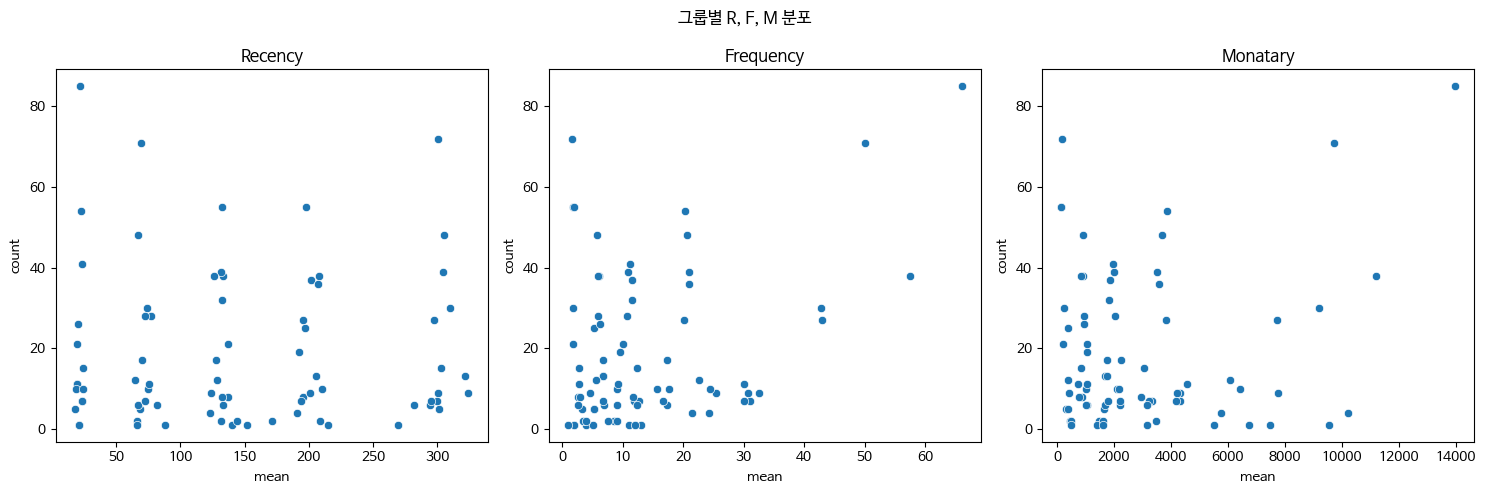

In [ ]:
# RFM스코어 그룰별 시각화해보기

fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(rfm_score_df.groupby('RFMScore')['R'].describe(), x='mean', y='count')
plt.title('Recency')

plt.subplot(132)
sns.scatterplot(rfm_score_df.groupby('RFMScore')['F'].describe(), x='mean', y='count')
plt.title('Frequency')

plt.subplot(133)
sns.scatterplot(rfm_score_df.groupby('RFMScore')['M'].describe(), x='mean', y='count')
plt.title('Monatary')

fig.suptitle('그룹별 R, F, M 분포')
plt.tight_layout()
plt.show()

In [ ]:
rfm_score_df.groupby('FScore')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FScore,,,,,,,,
1,294.0,2.000000,1.025278,1.0,1.0,2.0,3.0,4.0
2,293.0,5.945392,1.229108,4.0,5.0,6.0,7.0,8.0
3,294.0,10.938776,1.980190,8.0,9.0,11.0,13.0,15.0
4,293.0,20.358362,3.790477,15.0,17.0,20.0,23.0,28.0
5,294.0,51.428571,39.033372,28.0,33.0,39.0,55.0,328.0


In [ ]:
rfm_score_df.groupby('MScore')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MScore,,,,,,,,
1,294.0,226.899014,168.209440,6.99,68.1125,193.425,364.595,559.28
2,293.0,926.494471,222.042474,559.32,715.0200,944.940,1092.850,1339.68
3,294.0,1931.589694,358.137210,1342.55,1631.9850,1899.320,2210.040,2605.17
4,293.0,3703.175836,704.727700,2606.18,3114.9000,3637.140,4272.330,5052.54
5,294.0,10505.561429,9095.965301,5056.79,6361.9325,8038.825,11269.590,84405.83


- Monetary에서 FRMScore 그룹간 차이가 명확하지 않아보인다.
- Monetary 기준으로 구매 금액이 매우 큰 고객을 구별해보자.

---
# 매출에 큰 영향을 주는 총주문금액(M)을 기준으로 RFM 재구분
- 매출이 큰데 이탈 고객일 수도 있고, 매출이 적은데 이탈 고객일 수도 있다.
- 두 그룹을 다르게 접근해본다.

In [ ]:
percentiles = [0.20, 0.40, 0.60, 0.80, 0.90]
rfm_df['M'].describe(percentiles=percentiles)

count     1468.000000
mean      3460.302548
std       5519.945748
min          6.990000
20%        559.296000
40%       1341.976000
50%       1899.320000
60%       2605.372000
80%       5055.090000
90%       8032.211000
max      84405.830000
Name: M, dtype: float64

- 80% 값에 해당하는 값을 기준으로, 이 이상에 해당하는 고객을 제외 후 나머지로 재분류
- 90% 값으로 하면 제대로 그룹화되지 않음

In [ ]:
rfm_m90_df = rfm_df[rfm_df['M'] <= 8032]
rfm_m80_df = rfm_df[rfm_df['M'] <= 5056]
rfm_m80_df

,CustomerID,R,F,M
0,USER_0000,108,1,99.98
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
5,USER_0005,131,3,706.02
...,...,...,...,...
1462,USER_1462,180,2,70.85
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90


In [ ]:
# 5개 bins, 5점 기준으로 점수 부여
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["RScore"] = pd.qcut(df_["R"], 5, labels=[5, 4, 3, 2, 1])   # 5가 가장 높은 점수
    df_["FScore"] = pd.qcut(
        df_["F"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5]   # method = "first"는 순위 간 동률을 처리할 때 사용
    )
    df_["MScore"] = pd.qcut(df_["M"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFMScore"] = df_["RScore"].astype(str) + df_["FScore"].astype(str) + df_["MScore"].astype(str)   # RFMScore는 점수들의 str 조합

    return df_

rfm_m90_score_df = get_rfm_scores(rfm_m90_df)
rfm_m80_score_df = get_rfm_scores(rfm_m80_df)
rfm_m80_score_df

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore
0,USER_0000,108,1,99.98,4,1,1,411
2,USER_0002,74,8,1573.49,4,3,3,433
3,USER_0003,18,11,1421.96,5,4,3,543
4,USER_0004,108,13,1524.42,4,4,3,443
5,USER_0005,131,3,706.02,3,1,2,312
...,...,...,...,...,...,...,...,...
1462,USER_1462,180,2,70.85,2,1,1,211
1463,USER_1463,271,3,676.73,1,2,2,122
1464,USER_1464,88,19,2606.18,4,5,4,454
1465,USER_1465,195,2,127.90,2,1,1,211


In [ ]:
#transposition of the RFM table. This makes it easier to evaluate.
rfm_m80_score_df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,1174.0,154.390119,100.653277,1.00,70.00,144.000,227.75,365.00
F,1174.0,10.115843,7.862536,1.00,4.00,8.000,15.00,43.00
M,1174.0,1695.987291,1372.626706,6.99,559.29,1341.115,2604.10,5052.54


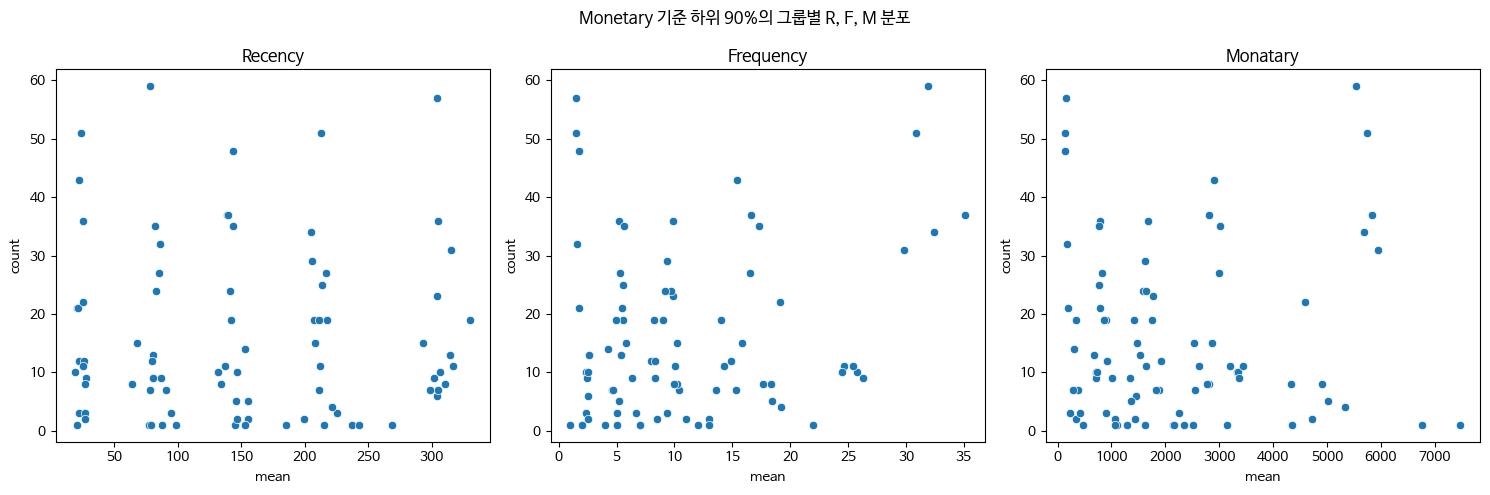

In [ ]:
# RFM스코어 그룰별 시각화해보기
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(rfm_m90_score_df.groupby('RFMScore')['R'].describe(), x='mean', y='count')
plt.title('Recency')

plt.subplot(132)
sns.scatterplot(rfm_m90_score_df.groupby('RFMScore')['F'].describe(), x='mean', y='count')
plt.title('Frequency')

plt.subplot(133)
sns.scatterplot(rfm_m90_score_df.groupby('RFMScore')['M'].describe(), x='mean', y='count')
plt.title('Monatary')

fig.suptitle('Monetary 기준 하위 90%의 그룹별 R, F, M 분포')
plt.tight_layout()
plt.show()

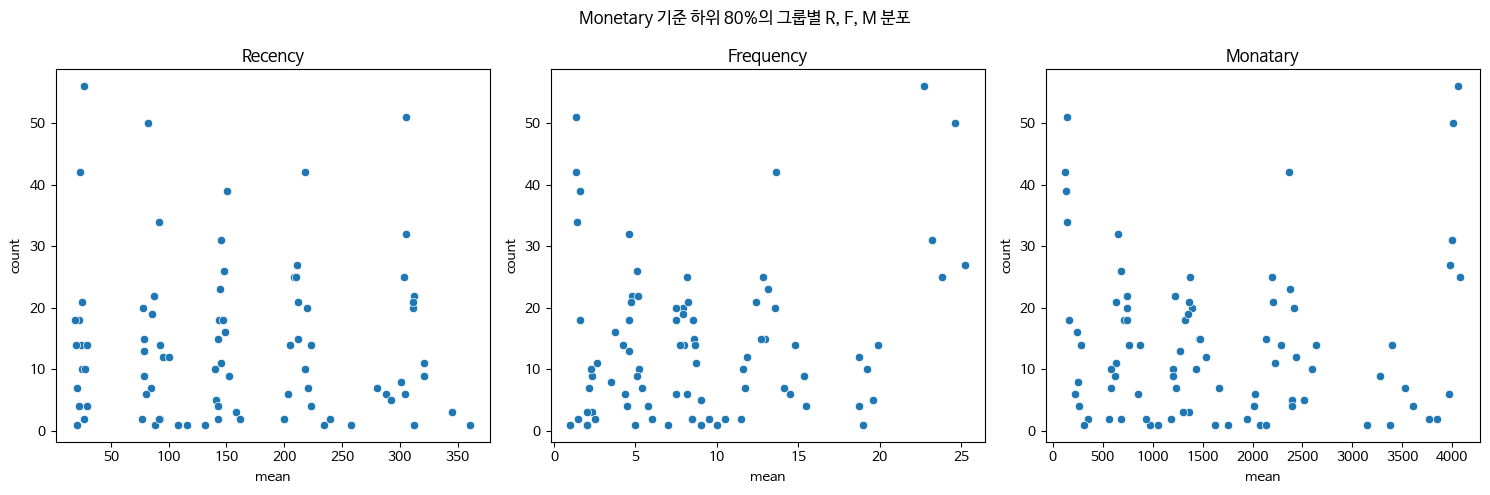

In [ ]:
# RFM스코어 그룰별 시각화해보기
fig = plt.figure(figsize=(15, 5))
plt.subplot(131)
sns.scatterplot(rfm_m80_score_df.groupby('RFMScore')['R'].describe(), x='mean', y='count')
plt.title('Recency')

plt.subplot(132)
sns.scatterplot(rfm_m80_score_df.groupby('RFMScore')['F'].describe(), x='mean', y='count')
plt.title('Frequency')

plt.subplot(133)
sns.scatterplot(rfm_m80_score_df.groupby('RFMScore')['M'].describe(), x='mean', y='count')
plt.title('Monatary')

fig.suptitle('Monetary 기준 하위 80%의 그룹별 R, F, M 분포')
plt.tight_layout()
plt.show()

In [ ]:
rfm_m80_score_df.groupby('RScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RScore,,,,,,,,
5,235.0,24.331915,12.058637,1.0,16.0,22.0,33.0,50.0
4,242.0,85.859504,19.369654,51.0,70.0,87.0,103.0,118.0
3,233.0,146.682403,16.210429,119.0,133.0,146.0,159.0,173.0
2,235.0,213.795745,23.269344,174.0,195.0,210.0,230.0,257.0
1,229.0,307.157205,34.573488,258.0,276.0,301.0,340.0,365.0


In [ ]:
rfm_m80_score_df.groupby('FScore')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FScore,,,,,,,,
1,235.0,1.625532,0.742618,1.0,1.0,1.0,2.0,3.0
2,235.0,4.714894,0.969399,3.0,4.0,5.0,5.0,6.0
3,234.0,8.115385,1.103807,6.0,7.0,8.0,9.0,10.0
4,235.0,13.195745,1.970938,10.0,11.5,13.0,15.0,17.0
5,235.0,22.919149,4.843475,17.0,19.0,22.0,26.0,43.0


In [ ]:
rfm_m80_score_df.groupby('MScore')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MScore,,,,,,,,
1,235.0,163.622936,120.938505,6.99,50.095,139.930,268.3850,384.09
2,235.0,701.971872,177.977010,384.14,559.300,680.450,853.5850,995.23
3,234.0,1361.443419,240.716806,998.66,1141.440,1341.115,1566.9525,1791.61
4,235.0,2326.336596,349.914934,1791.70,2028.150,2284.340,2603.0300,3001.02
5,235.0,3925.138043,605.363730,3007.00,3389.035,3863.260,4430.9850,5052.54


- Monetary 하위 80%를 5개 그룹으로 구분할 시 기준

In [ ]:
RFM_M80_Group_df = pd.DataFrame({'Group': [1, 2, 3, 4, 5],
                                   'R(day)' : ['258~365', '174~257', '119~173', '51~118', '1~50'],
                                   'F(Count)':['1~3', '3~6', '6~10', '10~17', '17~43'],
                                   'M(USD)' : ['7.0~384.09', '384.14~995.23', '998.66~1791.61', '1791.70~3001.02', '3007.0~5052.54']}).set_index('Group', drop=True)
RFM_M80_Group_df

,R(day),F(Count),M(USD)
Group,,,
1,258~365,1~3,7.0~384.09
2,174~257,3~6,384.14~995.23
3,119~173,6~10,998.66~1791.61
4,51~118,10~17,1791.70~3001.02
5,1~50,17~43,3007.0~5052.54


# Monetary 상위 20% 집단 확인하기

In [ ]:
rfm_m80_upper_df = rfm_df[rfm_df['M'] > 5056]
rfm_m80_upper_df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,294.0,108.962585,99.054241,1.00,33.2500,72.500,158.25,363.00
F,294.0,50.187075,39.841782,4.00,32.0000,39.000,55.00,328.00
M,294.0,10505.561429,9095.965301,5056.79,6361.9325,8038.825,11269.59,84405.83


- Monetary 기준으로만 발라내면 R과 F를 기준으로 공통된 성향을 찾기 어렵다.
- 구매액이 높은 고객군을 다시 RFM으로 재구분을 한다.
- 단, 1회 구매라도 구매금액이 높은 고객이기 때문에, 재유치만 한다면 다시 높은 매출을 창출할 수 있는 잠재고객일 수 있기 때문에 소수의 그룹으로 재분배하는 것도 의미가 있어보인다.

# 몇 개 그룹으로?

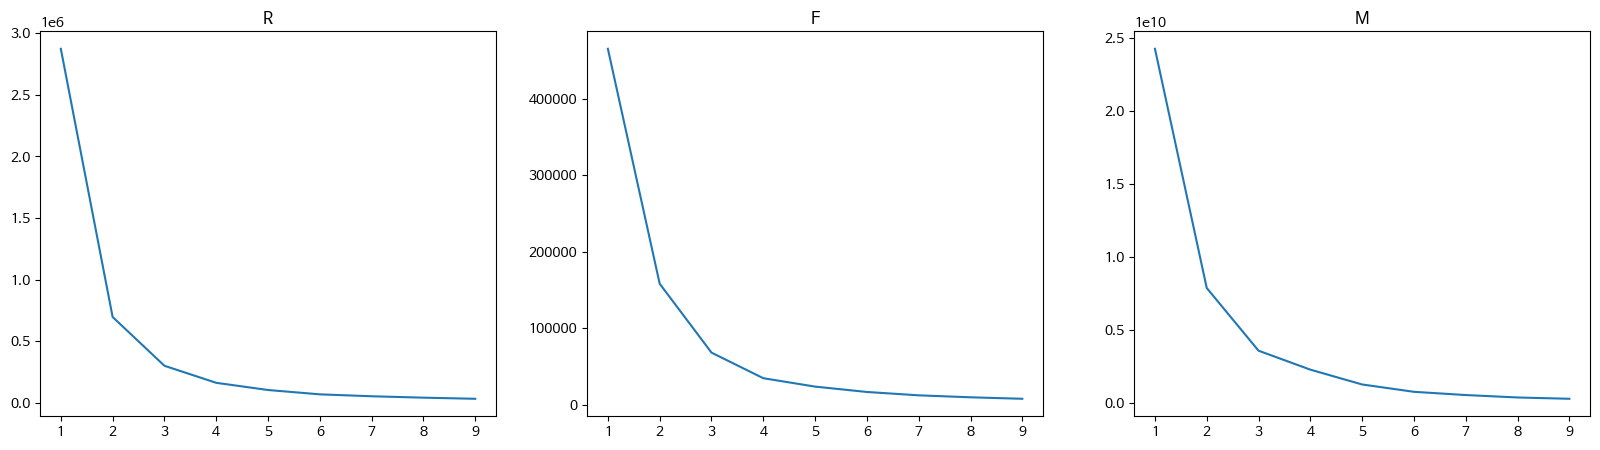

In [ ]:
# Recency kmeans 계산을 위한 elbow point: 엘보우 포인트는 클러스터의 수가 증가함에 따라 클러스터 내 오차 제곱합(SSE: Sum of Squared Errors)이 어떻게 변하는지를 보여줌. 엘보우 포인트는 SSE의 감소율이 급격하게 줄어드는 지점으로, 이 지점에서는 클러스터의 수를 증가시켜도 성능이 크게 향상되지 않는다는 것을 의미
from sklearn.cluster import KMeans

recency_point = {}
frequency_point = {}
monetary_point = {}

rfm_m80_upper_df_recency = rfm_m80_upper_df[['R']].copy()
rfm_m80_upper_df_frequency = rfm_m80_upper_df[['F']].copy()
rfm_m80_upper_df_monetary = rfm_m80_upper_df[['M']].copy()

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_recency)
  rfm_m80_upper_df_recency['cluster'] = kmeans.labels_
  recency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_frequency)
  rfm_m80_upper_df_frequency['cluster'] = kmeans.labels_
  frequency_point[k] = kmeans.inertia_

  kmeans = KMeans(n_clusters=k, max_iter=100).fit(rfm_m80_upper_df_monetary)
  rfm_m80_upper_df_monetary['cluster'] = kmeans.labels_
  monetary_point[k] = kmeans.inertia_

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

ax0 = sns.lineplot(ax=axes[0], x=list(recency_point.keys()), y=list(recency_point.values()))
ax0.set_title('R')

ax1 = sns.lineplot(ax=axes[1], x=list(frequency_point.keys()), y=list(frequency_point.values()))
ax1.set_title('F')

ax2 = sns.lineplot(ax=axes[2], x=list(monetary_point.keys()), y=list(monetary_point.values()))
ax2.set_title('M')
plt.show()

- 3개로 나눠보자

In [ ]:
# 5개 bins, 5점 기준으로 점수 부여
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:

    df_ = dataframe.copy()
    df_["RScore"] = pd.qcut(df_["R"], 3, labels=[3, 2, 1])   # 3이 가장 높은 점수
    df_["FScore"] = pd.qcut(
        df_["F"].rank(method="first"), 3, labels=[1, 2, 3]   # method = "first"는 순위 간 동률을 처리할 때 사용
    )
    df_["MScore"] = pd.qcut(df_["M"], 3, labels=[1, 2, 3])
    df_["RFMScore"] = df_["RScore"].astype(str) + df_["FScore"].astype(str) + df_["MScore"].astype(str)   # RFMScore는 점수들의 str 조합

    return df_

rfm_m80_upper_score_df = get_rfm_scores(rfm_m80_upper_df)
rfm_m80_upper_score_df

,CustomerID,R,F,M,RScore,FScore,MScore,RFMScore
1,USER_0001,60,31,15308.13,2,1,3,213
6,USER_0006,190,44,7708.11,1,2,2,122
8,USER_0008,41,37,10807.72,3,2,3,323
9,USER_0009,100,39,5572.17,2,2,1,221
25,USER_0025,41,32,6091.21,3,1,1,311
...,...,...,...,...,...,...,...,...
1433,USER_1433,107,120,21138.65,2,3,3,233
1435,USER_1435,49,45,11115.44,2,2,3,223
1459,USER_1459,35,27,6630.81,3,1,1,311
1460,USER_1460,34,30,8267.32,3,1,2,312


In [ ]:
rfm_m80_upper_score_df.groupby('RScore')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RScore,,,,,,,,
3,100.0,23.250000,11.903972,1.0,14.0,22.0,34.00,43.0
2,96.0,77.145833,21.685299,44.0,59.0,75.0,96.25,116.0
1,98.0,227.591837,78.985035,117.0,160.0,215.0,302.75,363.0


In [ ]:
rfm_m80_upper_score_df.groupby('FScore')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FScore,,,,,,,,
1,98.0,27.336735,6.001622,4.0,25.25,29.0,32.0,34.0
2,98.0,39.867347,3.721317,34.0,37.00,39.0,42.0,48.0
3,98.0,83.357143,54.756302,48.0,55.25,67.0,83.0,328.0


In [ ]:
rfm_m80_upper_score_df.groupby('MScore')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MScore,,,,,,,,
1,98.0,5915.533469,524.931303,5056.79,5496.8525,5894.820,6346.0775,6901.80
2,98.0,8075.860714,816.676262,6911.20,7338.6200,8038.825,8716.8800,10076.07
3,98.0,17525.290102,13112.539475,10088.81,11284.1700,12701.940,17695.7200,84405.83


- Monetary 상위 10%를 3개 그룹으로 분류한 기준

In [ ]:
RFM_M80_upper_Group_df = pd.DataFrame({'Group': [1, 2, 3],
                                       'R(day)' : ['117~363', '44~116', '1~43'],
                                       'F(Count)':['4~34', '34~48', '48~328'],
                                       'M(USD)' : ['5056.79~6091.80', '6911.20~10076.07', '10088.81~84405.83'],
                                       }).set_index('Group', drop=True)
RFM_M80_upper_Group_df

,R(day),F(Count),M(USD)
Group,,,
1,117~363,4~34,5056.79~6091.80
2,44~116,34~48,6911.20~10076.07
3,1~43,48~328,10088.81~84405.83


- 합치면

In [111]:
result_df = pd.concat([RFM_M80_Group_df, RFM_M80_upper_Group_df], axis=0)
result_df['GroupName'] = ['이탈', '이탈우려', '관심필요', '잠재우량', '우량', '관심필요(M)', '잠재우량(M)', '우량(M)']
result_df

,R(day),F(Count),M(USD),GroupName
Group,,,,
1,258~365,1~3,7.0~384.09,이탈
2,174~257,3~6,384.14~995.23,이탈우려
3,119~173,6~10,998.66~1791.61,관심필요
4,51~118,10~17,1791.70~3001.02,잠재우량
5,1~50,17~43,3007.0~5052.54,우량
1,117~363,4~34,5056.79~6091.80,관심필요(M)
2,44~116,34~48,6911.20~10076.07,잠재우량(M)
3,1~43,48~328,10088.81~84405.83,우량(M)


- 그룹별 인원수
- 인기 카테고리
- 인기 제품
- 쿠폰 민감도(사용비율)
- 마케팅 비용의 효과: 그룹별로 얼만큼 유입되었을까?
- 마케팅 비용 / 고객 수: -> 유입단가
- 마케팅 비용 / 그룹 별: -> 그룹별 유입단가?
- 그룹별로 마케팅 효과를 측정할 수 있다면? ab test

---

# 대량주문 고객을 발라낼 수 있다면?

In [ ]:
customer_buyinginfo_df['구매제품수'].describe(percentiles=percentiles)

count    1468.000000
mean      162.147820
std       312.374078
min         1.000000
20%        14.000000
40%        40.000000
50%        61.000000
60%        98.000000
80%       225.000000
90%       401.600000
max      4869.000000
Name: 구매제품수, dtype: float64

- 약 60% 정도의 값으로 101개부터 대량주문 고객으로 판단? 응ㅁ.......

---

# FRM Segmentation with Kmeans
### Recency 5개 그룹으로 분류하기

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_df[['R']])
rfm_df['RCluster'] = kmeans.predict(rfm_df[['R']])

#cluster 분석 모형
def order_cluster(cluster_field_name, target_field_name, df, ascending):
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(target_field_name, ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index
  df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
  df_final = df_final.drop([cluster_field_name], axis=1)
  df_final = df_final.rename(columns={'index':cluster_field_name})
  return df_final

tmp_df = order_cluster('RCluster', 'R', rfm_df, False)
tmp_df

,CustomerID,R,F,M,RCluster
0,USER_0000,108,1,99.98,3
1,USER_0002,74,8,1573.49,3
2,USER_0004,108,13,1524.42,3
3,USER_0005,131,3,706.02,3
4,USER_0009,100,39,5572.17,3
...,...,...,...,...,...
1463,USER_1398,342,33,5808.89,0
1464,USER_1406,350,13,1842.32,0
1465,USER_1421,364,12,2047.79,0
1466,USER_1431,299,1,139.07,0


In [ ]:
tmp_df.groupby('RCluster')['R'].describe()

,count,mean,std,min,25%,50%,75%,max
RCluster,,,,,,,,
0,148.0,335.722973,19.584744,297.0,322.5,337.0,350.0,365.0
1,227.0,256.325991,22.433567,217.0,236.0,258.0,271.0,296.0
2,311.0,176.935691,22.349476,141.0,157.0,173.0,196.0,216.0
3,350.0,104.777143,21.195002,69.0,88.0,105.0,124.0,140.0
4,432.0,31.752315,18.117335,1.0,18.0,28.0,45.0,67.0


- Recency 기준으로 KMeans를 이용해 5개의 cluster를 만들었다.
- 0이 가장 오래 전에 거래한 그룹, 4가 가장 최근에 거래한 그룹이다.
- 그룹 0의 Recency 평균은 335.5일, 그룹 4의 Recency 평균은 18.1일이다.

### Frequency 5개 그룹으로 분류하기

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_df[['F']])
rfm_df['FCluster'] = kmeans.predict(rfm_df[['F']])

#cluster 분석 모형
def order_cluster(cluster_field_name, target_field_name, df, ascending):
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(target_field_name, ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index
  df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
  df_final = df_final.drop([cluster_field_name], axis=1)
  df_final = df_final.rename(columns={'index':cluster_field_name})
  return df_final

tmp_df = order_cluster('FCluster', 'F', rfm_df, True)   #ascending=True 설정
tmp_df

,CustomerID,R,F,M,RCluster,FCluster
0,USER_0000,108,1,99.98,4,0
1,USER_0002,74,8,1573.49,4,0
2,USER_0003,18,11,1421.96,0,0
3,USER_0004,108,13,1524.42,4,0
4,USER_0005,131,3,706.02,4,0
...,...,...,...,...,...,...
1463,USER_0118,108,328,82405.58,4,4
1464,USER_0563,1,289,61651.34,0,4
1465,USER_0643,11,276,53883.43,0,4
1466,USER_0736,13,291,84405.83,0,4


In [ ]:
tmp_df.groupby('FCluster')['F'].describe()

,count,mean,std,min,25%,50%,75%,max
FCluster,,,,,,,,
0,995.0,7.470352,4.959988,1.0,3.00,7.0,11.00,18.0
1,360.0,28.713889,7.031471,19.0,23.00,28.0,33.25,44.0
2,92.0,59.597826,11.458535,45.0,49.75,57.0,68.25,88.0
3,16.0,120.687500,26.847020,94.0,99.75,115.5,127.75,177.0
4,5.0,289.400000,24.337214,263.0,276.00,289.0,291.00,328.0


- Frequency 기준으로 KMeans를 이용해 5개의 cluster를 만들었다.
- 0이 가장 적게 거래한 그룹, 4가 가장 많이 거래한 그룹이다.
- 그룹 0의 Frequency 평균은 6.8회, 그룹 4의 Frequency 평균은 289.4회이다.

### Monetary 5개 그룹으로 분류하기

In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(rfm_df[['M']])
rfm_df['MCluster'] = kmeans.predict(rfm_df[['M']])

#cluster 분석 모형
def order_cluster(cluster_field_name, target_field_name, df, ascending):
  df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  df_new = df_new.sort_values(target_field_name, ascending=ascending).reset_index(drop=True)
  df_new['index'] = df_new.index
  df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
  df_final = df_final.drop([cluster_field_name], axis=1)
  df_final = df_final.rename(columns={'index':cluster_field_name})
  return df_final

tmp_df = order_cluster('MCluster', 'M', rfm_df, True)   #ascending=True 설정
tmp_df['ClusterGroup'] = [str(row['RCluster']) + str(row['FCluster']) + str(row['MCluster']) for idx, row in tmp_df.iterrows()]
tmp_df

,CustomerID,R,F,M,RCluster,FCluster,MCluster,ClusterGroup
0,USER_0000,108,1,99.98,4,0,0,400
1,USER_0002,74,8,1573.49,4,0,0,400
2,USER_0003,18,11,1421.96,0,0,0,000
3,USER_0004,108,13,1524.42,4,0,0,400
4,USER_0005,131,3,706.02,4,0,0,400
...,...,...,...,...,...,...,...,...
1463,USER_0118,108,328,82405.58,4,4,4,444
1464,USER_0563,1,289,61651.34,0,4,4,044
1465,USER_0643,11,276,53883.43,0,4,4,044
1466,USER_0736,13,291,84405.83,0,4,4,044


In [ ]:
tmp_df.groupby('MCluster')['M'].describe()

,count,mean,std,min,25%,50%,75%,max
MCluster,,,,,,,,
0,905.0,1072.433923,784.502072,6.99,374.280,967.740,1691.3800,2762.74
1,383.0,4470.735822,1227.012337,2767.72,3403.620,4239.610,5403.7050,7127.25
2,149.0,9960.150067,2170.041371,7239.19,8138.410,9305.990,11482.7000,15984.29
3,26.0,22321.573462,5952.065321,16332.71,17960.645,21576.545,22982.2925,39126.84
4,5.0,66491.270000,16007.183636,50110.17,53883.430,61651.340,82405.5800,84405.83


- Monetary 기준으로 KMeans를 이용해 5개의 cluster를 만들었다.
- 0이 가장 구매액이 작은 그룹, 4가 가장 구매액이 큰 그룹이다.
- 그룹 0의 Monetary 평균은 1072.4달러, 그룹 4의 Monetary 평균은 66491.3달러이다.

위의 기준으로 분류하는 경우, 그 기준은 아래 테이블과 같다.

In [ ]:
RFMGroup_with_kmeans_df = pd.DataFrame({'Group': [0, 1, 2, 3, 4],
                                   'R(day)' : ['296~365', '217~294', '141~216', '69~140', '1~67'],
                                   'F(Count)':['5~16', '17~40', '41~85', '88~177', '263~328'],
                                   'M(USD)' : ['7.0~2762.7', '2767.7~7127.3', '7239.2~15984.3', '16332.7~39126.8', '50110.2~84405.8']}).set_index('Group', drop=True)
RFMGroup_with_kmeans_df

,R(day),F(Count),M(USD)
Group,,,
0,296~365,5~16,7.0~2762.7
1,217~294,17~40,2767.7~7127.3
2,141~216,41~85,7239.2~15984.3
3,69~140,88~177,16332.7~39126.8
4,1~67,263~328,50110.2~84405.8


- 참고: https://stelch.tistory.com/pages/CRM-RFM-%EA%B3%A0%EA%B0%9D%EA%B0%80%EC%B9%98%EB%B6%84%EC%84%9D-feat-%ED%8C%8C%EC%9D%B4%EC%8D%AC-%ED%99%9C%EC%9A%A9

---